#**Abstract**
## To solve medical segmentation problem about spread through air spaces(STAS),we construct a Unet model with attention block followed by decoder,whose encoder is EfficientNetB3.We also use data augmentation technique to generalize our model capability.The training f1score is 0.865 ± 0.005.The future work we will try to add Atrous Spatial Pyramid Pooling （ASPP）technique or try Unet3plus architecture to get better result. 

#**1.PACKAGE**
##Python == 3.7.13
##torch == 1.11.0
##numpy == 1.21.6
##Pillow == 7.1.2
##Scikit-learn == 1.0.2
##OpenCV == 4.1.2.30
##albumentations == 0.1.12
##segmentation-models-pytorch == 0.2.1
##inplace-abn == 1.1.0

#**2.Directory**
## due to use of colab,the file directory needs modifying in Section Load & Process Data 
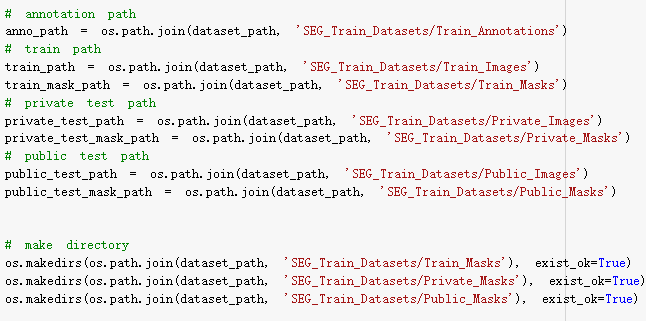

#**3.Data Augmentaion Block**
## make sure that we have albumentations packages,or you can use this command:
## install -U git+https://github.com/albu/albumentations --no-cache-dir

#**4.Create Model**
## make sure that we have segmentation-models-pytorch packages,or you can use this command:
## pip install segmentation-models-pytorch
## make sure that we have inplace-abn packages,or you can use this command:
## pip install inplace-abn

##**5.Reference**
#http://jase.tku.edu.tw/articles/jase-202212-25-6-0012
#https://arxiv.org/ftp/arxiv/papers/1910/1910.08978.pdf
#https://arxiv.org/pdf/1505.04597.pdf


#**import package**

In [ ]:
!pip install opencv-python-headless==4.5.2.52
# system
import os
import glob
from google.colab import drive

# data process
import numpy as np
import json
from sklearn.model_selection import train_test_split

# image process
import PIL
from PIL import Image
import cv2

# plot
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 38.2 MB 184 kB/s 


In [ ]:
# dataset path
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/Colab Notebooks/AICUP'

"""
DATA_DIR_train = dataset_path + 'Train'
DATA_DIR_vail = dataset_path + 'Valid'
DATA_DIR_test = dataset_path + 'Test'
"""

Mounted at /content/drive


"\nDATA_DIR_train = dataset_path + 'Train'\nDATA_DIR_vail = dataset_path + 'Valid'\nDATA_DIR_test = dataset_path + 'Test'\n"

#**Load and Process Data**
## 1. Load data
## 2. Split data to train and valid

In [ ]:
# preprocess

# annotation path
anno_path = os.path.join(dataset_path, 'SEG_Train_Datasets/Train_Annotations')
# train path
train_path = os.path.join(dataset_path, 'SEG_Train_Datasets/Train_Images')
train_mask_path = os.path.join(dataset_path, 'SEG_Train_Datasets/Train_Masks')
# private test path
private_test_path = os.path.join(dataset_path, 'SEG_Train_Datasets/Private_Images')
private_test_mask_path = os.path.join(dataset_path, 'SEG_Train_Datasets/Private_Masks')
# public test path
public_test_path = os.path.join(dataset_path, 'SEG_Train_Datasets/Public_Images')
public_test_mask_path = os.path.join(dataset_path, 'SEG_Train_Datasets/Public_Masks')


# make directory
os.makedirs(os.path.join(dataset_path, 'SEG_Train_Datasets/Train_Masks'), exist_ok=True)
os.makedirs(os.path.join(dataset_path, 'SEG_Train_Datasets/Private_Masks'), exist_ok=True)
os.makedirs(os.path.join(dataset_path, 'SEG_Train_Datasets/Public_Masks'), exist_ok=True)

# training dataset preprocess
x_train = []
y_train = []
for jsonfile in os.listdir(anno_path):
    anno_file = os.path.join(anno_path, jsonfile)
    f = open(anno_file)
    data = json.load(f)
    mask = np.zeros((data['imageHeight'], data['imageWidth'], 1), dtype=np.uint8)
    for polygan in data['shapes']:
        pts = np.array(polygan['points'], dtype=np.int32)
        cv2.fillPoly(mask, [pts], color=255)
    # x train
    save_train_path = jsonfile.split('.')[0] + '.jpg'
    save_train_path = os.path.join(train_path, save_train_path)
    x_train.append(save_train_path)
    # y train
    save_mask_path = jsonfile.split('.')[0] + '.png'
    save_mask_path = os.path.join(train_mask_path, save_mask_path)
    y_train.append(save_mask_path)
    cv2.imwrite(save_mask_path, mask)

# private testing dataset preprocess
private_x_test = []
for imagefile in os.listdir(private_test_path):
    test_file = os.path.join(private_test_path, imagefile)
    private_x_test.append(test_file)

# private testing dataset preprocess
public_x_test = []
for imagefile in os.listdir(public_test_path):
    test_file_public = os.path.join(public_test_path, imagefile)
    public_x_test.append(test_file_public)
    

In [ ]:
# split into train, valid, test
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.3, random_state=42)
# x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=0.5, random_state=21)

In [ ]:
x_train_dir = os.path.join(dataset_path, 'img')
y_train_dir = os.path.join(dataset_path,'label')

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 16))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

#**DataSet**


In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import torch.nn.functional as F

In [ ]:
# train dataset
class TrainDataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['bg', 'stas']
    
    def __init__(
            self, 
            images, 
            masks, 
            classes=None, 
            augmentation=None, 
            preprocessing=None
    ):
        # self.ids = os.listdir(images_dir)
        # self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids] # list
        # self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids] # list
        self.images_fps = images
        self.masks_fps = masks
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        # self.masks_fps[i] = self.masks_fps[i].replace('.jpg','.png')
        image = cv2.imread(self.images_fps[i])
        # print(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if image.shape != (800, 800, 3):
            image = cv2.resize(image, (800, 800), interpolation=cv2.INTER_LANCZOS4)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        if mask.shape != (800, 800, 3):
            mask = cv2.resize(mask, (800, 800), interpolation=cv2.INTER_LANCZOS4)  
        mask = mask.astype('bool')
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_fps)

In [ ]:
# test dataset
class TestDataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['bg', 'stas']
    
    def __init__(
            self, 
            images, 
            classes=None,
            preprocessing=None 
    ):
        # self.ids = os.listdir(images_dir)
        # self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids] # list
        # self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids] # list
        self.images_fps = images
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.preprocessing = preprocessing
    
    def __getitem__(self, i): 
        # read data
        # self.masks_fps[i] = self.masks_fps[i].replace('.jpg','.png')
        image = cv2.imread(self.images_fps[i])
        # print(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if image.shape != (800, 800, 3):
            image = cv2.resize(image, (800, 800), interpolation=cv2.INTER_LANCZOS4)
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']

        return image
        
    def __len__(self):
        return len(self.images_fps)

In [ ]:
# Lets look at data we have

train_dataset = TrainDataset(x_train, y_train, classes=['stas'])
valid_dataset = TrainDataset(x_valid, y_valid, classes=['stas'])
private_test_dataset = TestDataset(private_x_test, classes=['stas'])

image, mask = train_dataset[4] # get some sample
visualize(
    image=image, 
    stas_mask=mask.squeeze(),
)

#**Data Augmentation**

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
import albumentations as albu

def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.Rotate(limit=40,p=1,border_mode=cv2.BORDER_CONSTANT),
        albu.VerticalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=cv2.BORDER_CONSTANT),
        
        albu.HueSaturationValue(p=0.6),
        albu.Sharpen(p=0.5),
        albu.RandomBrightnessContrast(p=0.4),

        albu.Crop(x_min=0, y_min=0, x_max=800, y_max=750, p=0.5),
        albu.PadIfNeeded(800, 800)

        
    ]
    return albu.Compose(train_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_train_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def get_test_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor),
    ]
    return albu.Compose(_transform)

In [ ]:
#### Visualize resulted augmented images and masks

augmented_dataset = TrainDataset(
    x_train, 
    y_train, 
    augmentation=get_training_augmentation(), 
    classes=['stas'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

## **Create Model**

In [ ]:
!pip install segmentation_models_pytorch
import torch
import numpy as np
import segmentation_models_pytorch as smp
from torch import nn

In [ ]:
!pip install inplace-abn
from inplace_abn import InPlaceABN
ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['stas']
ACTIVATION = 'sigmoid' 
DEVICE = 'cuda'


'''
# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
    decoder_attention_type='scse',
    decoder_use_batchnorm=InPlaceABN
)'''

model = smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,

)


preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
train_dataset = TrainDataset(
    x_train, 
    y_train, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_train_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = TrainDataset(
    x_valid, 
    y_valid, 
    preprocessing=get_train_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, pin_memory=True, batch_size=4, shuffle=True, num_workers=16)
valid_loader = DataLoader(valid_dataset, pin_memory=True, batch_size=4, shuffle=False, num_workers=16)

#**Define Hyper Parameter and Optimizer**

In [ ]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.Fscore(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

# **Training Model**

In [ ]:
path='/data/home/VGH_Seg_IMG_Label/result/model'
# os.makedirs(path)

In [ ]:
max_score = 0

train_loss_list = []
train_fscore_list = []
valid_loss_list = []
valid_fcore_list = []

for i in range(32):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    train_loss_list.append(train_logs['dice_loss'])
    train_fscore_list.append(train_logs['fscore'])
    
    valid_loss_list.append(valid_logs['dice_loss'])
    valid_fcore_list.append(valid_logs['fscore'])
    

    if max_score < valid_logs['fscore']:
        max_score = valid_logs['fscore']
        torch.save(model, '/content/drive/MyDrive/Colab Notebooks/AICUP/best_mode_FPN_efficientnet-b3_aug.pth')
        print('Model saved!')

        
    if i == 35:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

In [ ]:
    plt.figure(0)
plt.plot(train_fscore_list)
plt.plot(valid_fcore_list)
plt.title('Train Logs')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')

plt.figure(1)
plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.title('Train Logs')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')


plt.show()

# **Load Best Model To Evalute Testsets**

In [ ]:
# load best saved checkpoint
best_model = torch.load('/content/drive/MyDrive/Colab Notebooks/AICUP/best_mode_FPN_efficientnet-b3_aug.pth')

In [ ]:
test_dataset = TestDataset(
    private_x_test, 
    preprocessing=get_test_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)


logs = test_epoch.run(test_dataloader)

'test_epoch = smp.utils.train.ValidEpoch(\n    model=best_model,\n    loss=loss,\n    metrics=metrics,\n    device=DEVICE,\n)\n\nlogs = test_epoch.run(test_dataloader)'

# **Visulization and Save Results**

In [ ]:
# test dataset
class VisTestDataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['bg', 'stas']
    
    def __init__(
            self, 
            images, 
            classes=None,
            preprocessing=None 
    ):
        # self.ids = os.listdir(images_dir)
        # self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids] # list
        # self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids] # list
        self.images_fps = images
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.preprocessing = preprocessing
    
    def __getitem__(self, i): 
        # read data
        # self.masks_fps[i] = self.masks_fps[i].replace('.jpg','.png')
        image = cv2.imread(self.images_fps[i])
        # print(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']

        return image
        
    def __len__(self):
        return len(self.images_fps)

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = VisTestDataset(
    private_x_test, 
    classes=CLASSES,
)

In [ ]:
out_path='mask_example_FPN_efficientnet-b3_aug'
# os.makedirs(out_path)

In [ ]:
for i in range(len(test_dataset_vis)):
    
    image_vis = test_dataset_vis[i].astype('uint8')
    image = test_dataset[i]
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    len(pr_mask)
#     print(gt_mask.shape)
    zeros = np.zeros((800, 800, 3))
#    zeros[...,0] = pr_mask
    zeros[...,0] = pr_mask
    zeros[...,1] = pr_mask
    zeros[...,2] = pr_mask
#    zeros = cv2.resize(zeros, (1920, 828))
    print(image_vis.shape)
    zeros = cv2.resize(zeros, (image_vis.shape[1], image_vis.shape[0]))
#     print(i)
    visualize( 
            image=image_vis, 
            # ground_truth_mask=gt_mask.transpose(1, 2, 0)[...,0], 
            predicted_mask=pr_mask
        )


    plt.imsave(os.path.join(private_test_mask_path, private_x_test[i].split('/')[-1].replace('.jpg','.png')), zeros)
#     plt.imshow(zeros)
#     plt.show()
#     print(os.path.join(out_path, name.replace('.jpg','.png')))
    
    

In [ ]:
test_dataset_vis_public = VisTestDataset(
    public_x_test, 
    classes=CLASSES,
)
test_dataset_public = TestDataset(
    public_x_test, 
    preprocessing=get_test_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader_public = DataLoader(test_dataset_public)

In [ ]:
for i in range(len(test_dataset_vis_public)):
    
    image_vis = test_dataset_vis_public[i].astype('uint8')
    image = test_dataset_public[i]
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    len(pr_mask)
#     print(gt_mask.shape)
    zeros = np.zeros((800, 800, 3))
#    zeros[...,0] = pr_mask
    zeros[...,0] = pr_mask
    zeros[...,1] = pr_mask
    zeros[...,2] = pr_mask
#    zeros = cv2.resize(zeros, (1920, 828))
    print(image_vis.shape)
    zeros = cv2.resize(zeros, (image_vis.shape[1], image_vis.shape[0]))
#     print(i)
    visualize( 
            image=image_vis, 
            # ground_truth_mask=gt_mask.transpose(1, 2, 0)[...,0], 
            predicted_mask=pr_mask
        )


    plt.imsave(os.path.join(public_test_mask_path, public_x_test[i].split('/')[-1].replace('.jpg','.png')), zeros)
#     plt.imshow(zeros)
#     plt.show()
#     print(os.path.join(out_path, name.replace('.jpg','.png')))
    
    